## Download dataset

In [1]:
!wget https://assets.gezdev.com/banana/BananaDatasetDiscreteFullImage.tar.gz

In [ ]:
!wget https://assets.gezdev.com/banana/BananaDatasetDiscreteTextureImage.tar.gz

In [ ]:
!tar -xvf BananaDatasetDiscreteFullImage.tar.gz


 49650K .......... .......... .......... .......... .......... 15% 7.39M 1m47s
 49700K .......... .......... .......... .......... .......... 15%  996K 1m47s
 49750K .......... .......... .......... .......... .......... 15% 6.86M 1m47s
 49800K .......... .......... .......... .......... .......... 15% 1.29M 1m47s
 49850K .......... .......... .......... .......... .......... 15% 5.29M 1m47s
 49900K .......... .......... .......... .......... .......... 15% 6.90M 1m47s
 49950K .......... .......... .......... .......... .......... 15%  991K 1m47s
 50000K .......... .......... .......... .......... .......... 15% 4.04M 1m47s
 50050K .......... .......... .......... .......... .......... 15% 1.03M 1m47s
 50100K .......... .......... .......... .......... .......... 15% 6.11M 1m47s
 50150K .......... .......... .......... .......... .......... 15%  956K 1m47s
 50200K .......... .......... .......... .......... .......... 15% 11.4M 1m47s
 50250K .......... .......... .......... ..........

In [ ]:
!tar -xvf BananaDatasetDiscreteTextureImage.tar.gz

# Import Libs

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Set Training/Testing DIR

#### For Colab

In [ ]:
train_dataset_path='/content/BananaDatasetDiscreteFullImage/train'

In [5]:
test_dataset_path='/content/BananaDatasetDiscreteFullImage/test'

#### For Jupyter

In [2]:
train_dataset_path='D:/Source/FruitRipenning/BananaDatasetDiscreteFullImage/train'

In [7]:
test_dataset_path='D:/Source/FruitRipenning/BananaDatasetDiscreteFullImage/test'

In [2]:
save_model_path = 'D:/Source/FruitRipenning/bananaModel/'

## In case of keeping model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_model_path = '/content/drive/MyDrive/bananaModel/'

## Set Training Detail

In [5]:
img_height=299
img_width=299
batch_size=16

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1235 files belonging to 8 classes.
Using 988 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
number of class = 8


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1235 files belonging to 8 classes.
Using 247 files for validation.


In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 240 files belonging to 8 classes.


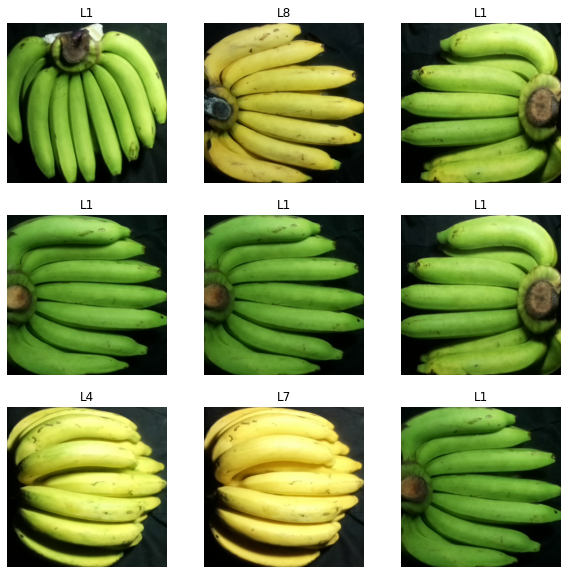

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  #layers.RandomFlip("vertical"),
  #layers.RandomRotation(0.2),
  #layers.RandomZoom(height_factor=0.1),
  #layers.RandomContrast(0.05),
])

In [12]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [14]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 299, 299, 3)
(16,)


In [15]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [ ]:
#custom_inceptionv3_model.trainable = False
#for layer in custom_inceptionv3_model.layers:
#    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

In [ ]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [16]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 23,909,160
Trainable params: 23,874,728
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
class_names = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']

4


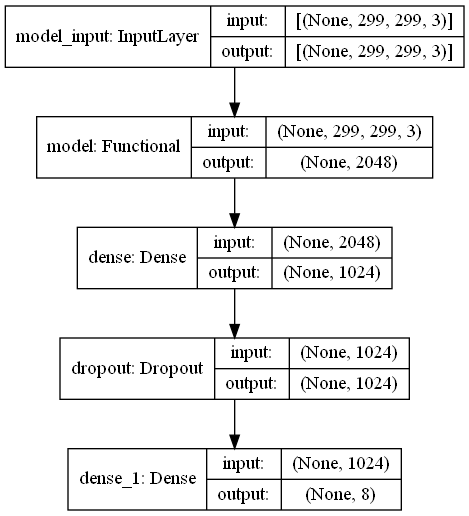

In [ ]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [3]:
path_to_model = save_model_path + 'FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/'

In [19]:
EPOCHS = 1000
save_model_interval = 100
checkpoint_filepath = path_to_model+'FullImage-Incepv3-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.0001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr]) #

Epoch 1/1000
62/62 [==============================] - 31s 250ms/step - loss: 1.6160 - accuracy: 0.4221 - val_loss: 10.6263 - val_accuracy: 0.1093
Epoch 2/1000
62/62 [==============================] - 10s 166ms/step - loss: 1.1444 - accuracy: 0.5283 - val_loss: 9.4218 - val_accuracy: 0.2753
Epoch 3/1000
62/62 [==============================] - 10s 166ms/step - loss: 1.0316 - accuracy: 0.5820 - val_loss: 4.5558 - val_accuracy: 0.2105
Epoch 4/1000
62/62 [==============================] - 10s 166ms/step - loss: 0.9546 - accuracy: 0.5911 - val_loss: 5.3255 - val_accuracy: 0.4818
Epoch 5/1000
62/62 [==============================] - 10s 165ms/step - loss: 0.8507 - accuracy: 0.6184 - val_loss: 3.7431 - val_accuracy: 0.5223
Epoch 6/1000
62/62 [==============================] - 10s 164ms/step - loss: 0.7640 - accuracy: 0.6751 - val_loss: 2.6615 - val_accuracy: 0.5020
Epoch 7/1000
62/62 [==============================] - 10s 164ms/step - loss: 0.6761 - accuracy: 0.7156 - val_loss: 4.6432 - val_a

Text(0.5, 1.0, 'Training and Validation Accuracy')

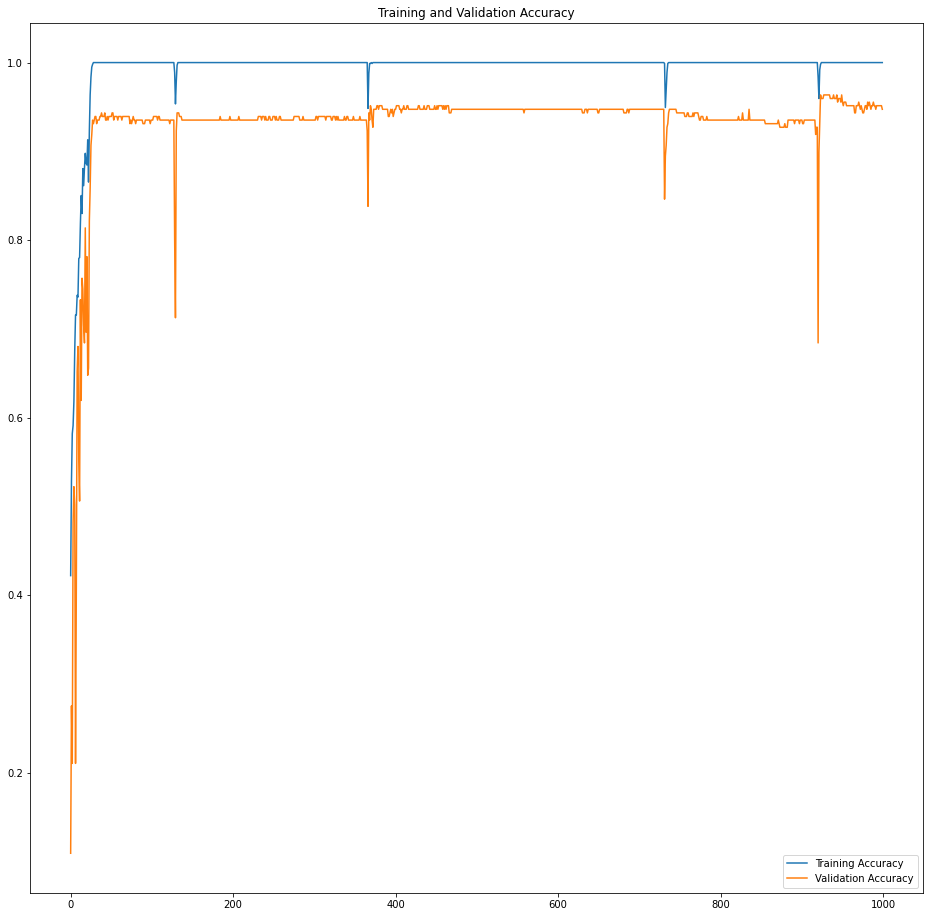

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


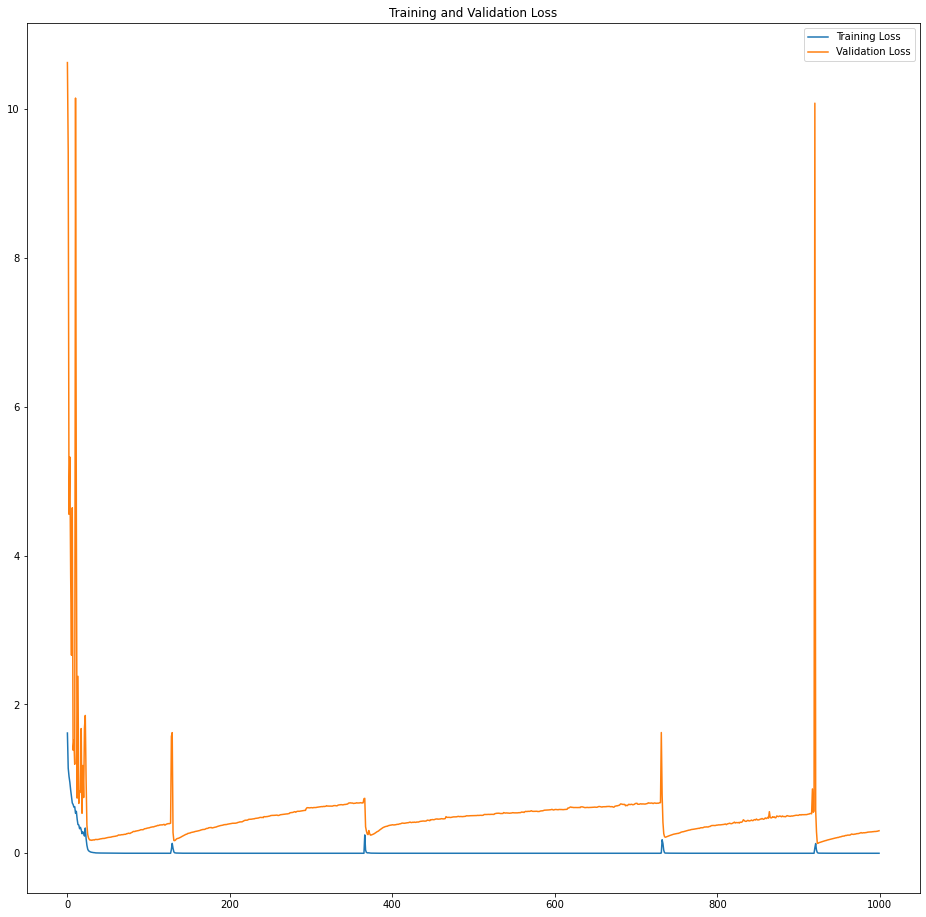

In [21]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#testset
test_ds_results = model.evaluate(test_ds)
print("test_ds_results:test loss, test acc:", test_ds_results)

15/15 [==============================] - 1s 47ms/step - loss: 3.6358 - accuracy: 0.5833 0s - loss: 3.7963 - accura
test_ds_results:test loss, test acc: [3.6358230113983154, 0.5833333134651184]


In [23]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0100-val_acc0.94.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0200-val_acc0.94.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0300-val_acc0.94.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0400-val_acc0.95.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0500-val_acc0.95.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0600-val_acc0.95.pb',
 'D:/Source/FruitRipenning/bananaModel/FullImage-Incepv3_LowDeepDense1024-FlipVer-NormalLR_01/FullImage-Incepv3-epoch0700-val_acc0.95.pb',
 'D:/Source/FruitRipenning/

# Testing in testset

In [24]:
test_acc = []
test_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    test_results = loaded_model.evaluate(test_ds)
    test_loss.append(test_results[0]) # append loss
    test_acc.append(test_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_acc={test_acc[lm_idx]} \n  test_loss={test_loss[lm_idx]} ")

15/15 [==============================] - 2s 47ms/step - loss: 2.5994 - accuracy: 0.5958
Epoch100 
 test_acc=0.5958333611488342 
  test_loss=2.5994157791137695 
15/15 [==============================] - 2s 47ms/step - loss: 3.2784 - accuracy: 0.5750
Epoch200 
 test_acc=0.574999988079071 
  test_loss=3.278414487838745 
15/15 [==============================] - 2s 48ms/step - loss: 4.7411 - accuracy: 0.5667
Epoch300 
 test_acc=0.5666666626930237 
  test_loss=4.74108362197876 
15/15 [==============================] - 2s 47ms/step - loss: 3.1163 - accuracy: 0.5792
Epoch400 
 test_acc=0.5791666507720947 
  test_loss=3.1163129806518555 
15/15 [==============================] - 2s 47ms/step - loss: 4.2576 - accuracy: 0.6042
Epoch500 
 test_acc=0.6041666865348816 
  test_loss=4.257608413696289 
15/15 [==============================] - 2s 47ms/step - loss: 4.9575 - accuracy: 0.5833
Epoch600 
 test_acc=0.5833333134651184 
  test_loss=4.95751428604126 
15/15 [==============================] - 2s 47m

range(100, 1100, 100)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

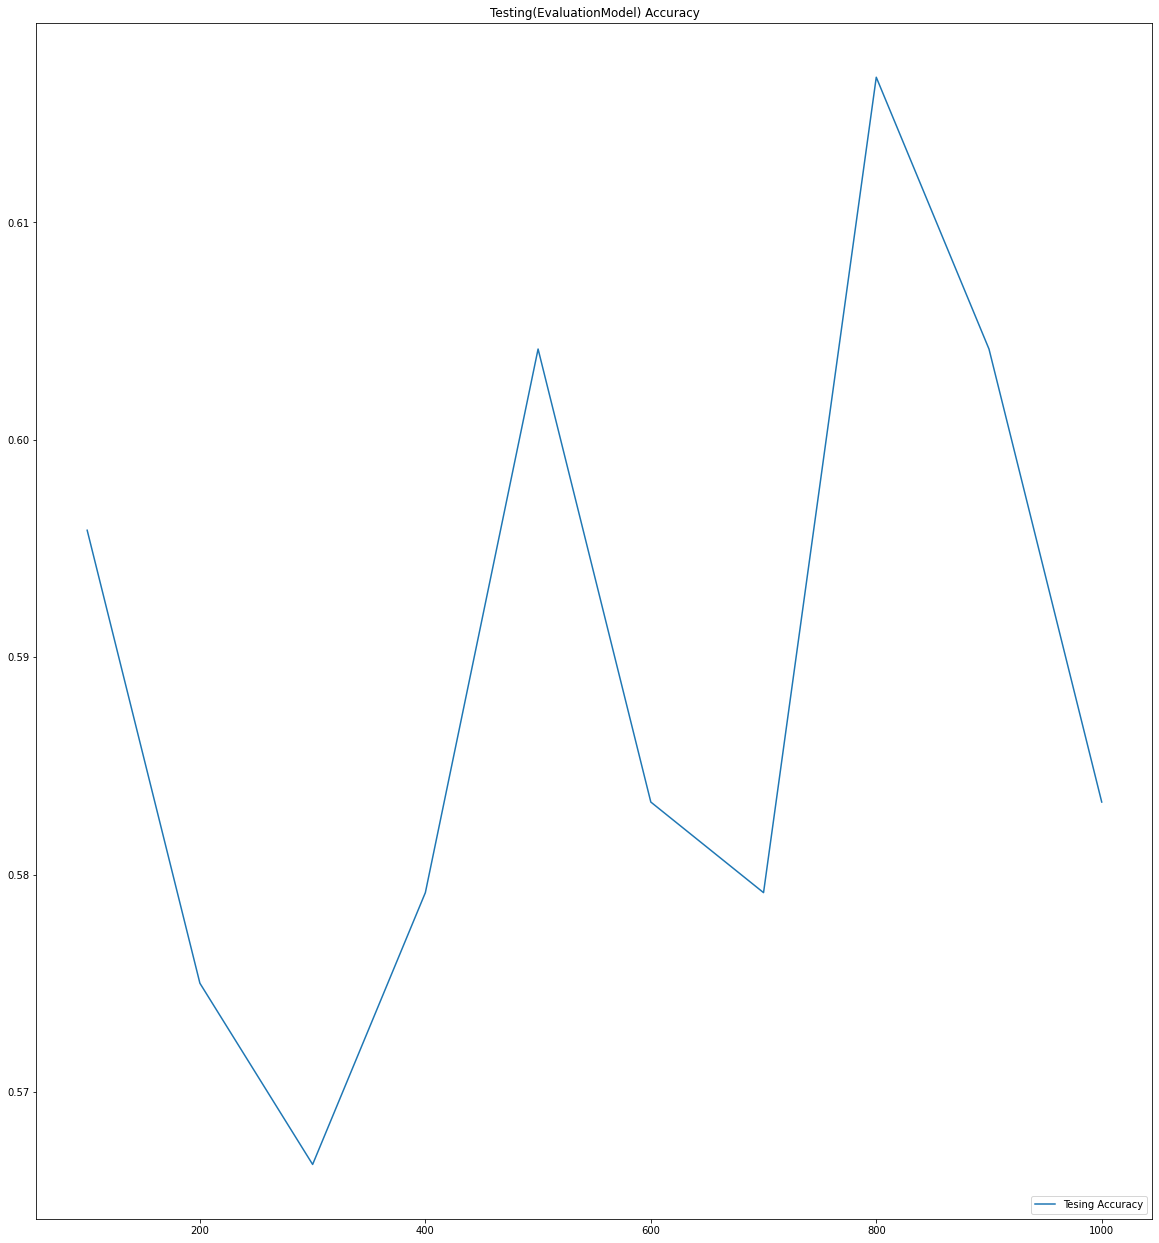

In [25]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_acc, label='Tesing Accuracy')

plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [26]:
#Find Max Index and Value
print(f"max acc -> {max(test_acc)}")
max_index = test_acc.index(max(test_acc))
#print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.6166666746139526
The [Epoch] of max acc -> 800


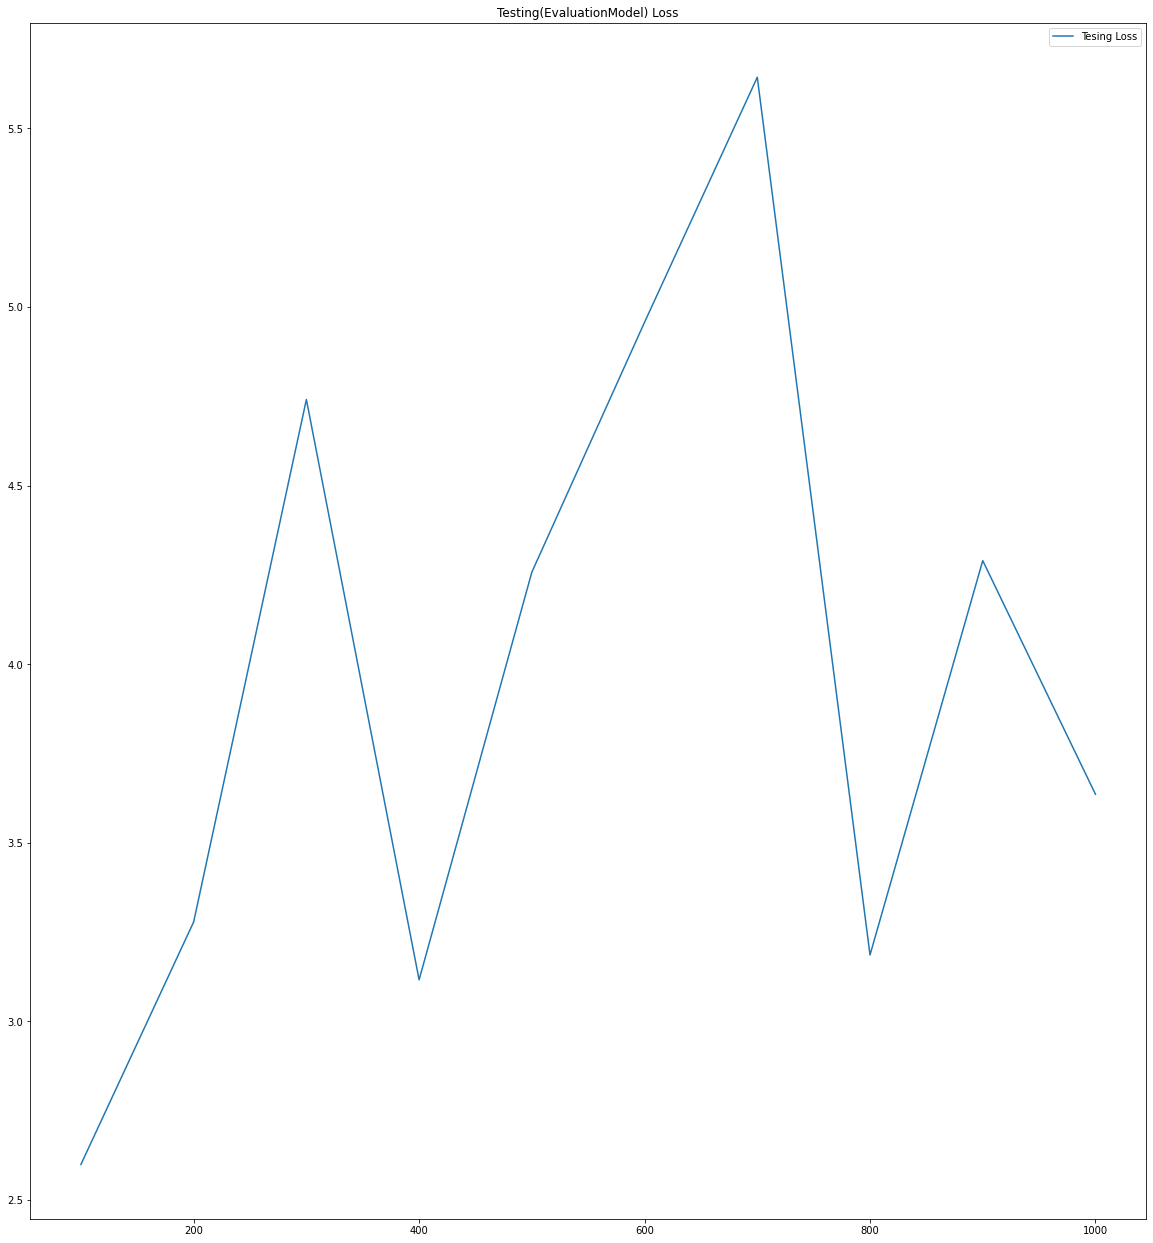

In [27]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_loss, label='Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [28]:
test_acc

[0.5958333611488342,
 0.574999988079071,
 0.5666666626930237,
 0.5791666507720947,
 0.6041666865348816,
 0.5833333134651184,
 0.5791666507720947,
 0.6166666746139526,
 0.6041666865348816,
 0.5833333134651184]

In [29]:
test_loss

[2.5994157791137695,
 3.278414487838745,
 4.74108362197876,
 3.1163129806518555,
 4.257608413696289,
 4.95751428604126,
 5.643407821655273,
 3.1859545707702637,
 4.289973258972168,
 3.6358230113983154]

## Load Last Epoch and test in each class

In [46]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'FullImage-Incepv3-epoch0800-val_acc0.94.pb')

test_dataset_path=test_dataset_path

img_height=299
img_width=299
batch_size=64

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)



normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"),
  #layers.RandomRotation(0.2),
  #layers.RandomZoom(height_factor=0.1),
  #layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = prepare(test_ds)


class_names = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']

x_all = np.concatenate([ x for x,y in test_ds],axis=0)

y_all = np.concatenate([ y for x,y in test_ds],axis=0)

print(f"All num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 240 files belonging to 8 classes.
All num x,y :240,240


In [9]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=240
TP=148
FP=92
acc=0.6166666666666667
all check = 240


In [10]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


L1 acc = 100.0%
L2 acc = 63.33333333333333%
L3 acc = 36.666666666666664%
L4 acc = 66.66666666666666%
L5 acc = 13.333333333333334%
L6 acc = 53.333333333333336%
L7 acc = 86.66666666666667%
L8 acc = 73.33333333333333%



all_avg_eachclass = 61.66666666666666%


In [11]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[30,  0,  0,  0,  0,  0,  0,  0],
       [11, 19,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 11,  0,  0,  0,  0,  0],
       [ 0,  0, 10, 20,  0,  0,  0,  0],
       [ 0,  0,  0, 26,  4,  0,  0,  0],
       [ 0,  0,  0,  0, 14, 16,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 26,  2],
       [ 0,  0,  0,  0,  0,  0,  8, 22]], dtype=int64)

In [12]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[100.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 36.66666667,  63.33333333,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  63.33333333,  36.66666667,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  33.33333333,  66.66666667,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  86.66666667,
         13.33333333,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         46.66666667,  53.33333333,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   6.66666667,  86.66666667,   6.66666667],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.       

<AxesSubplot:>

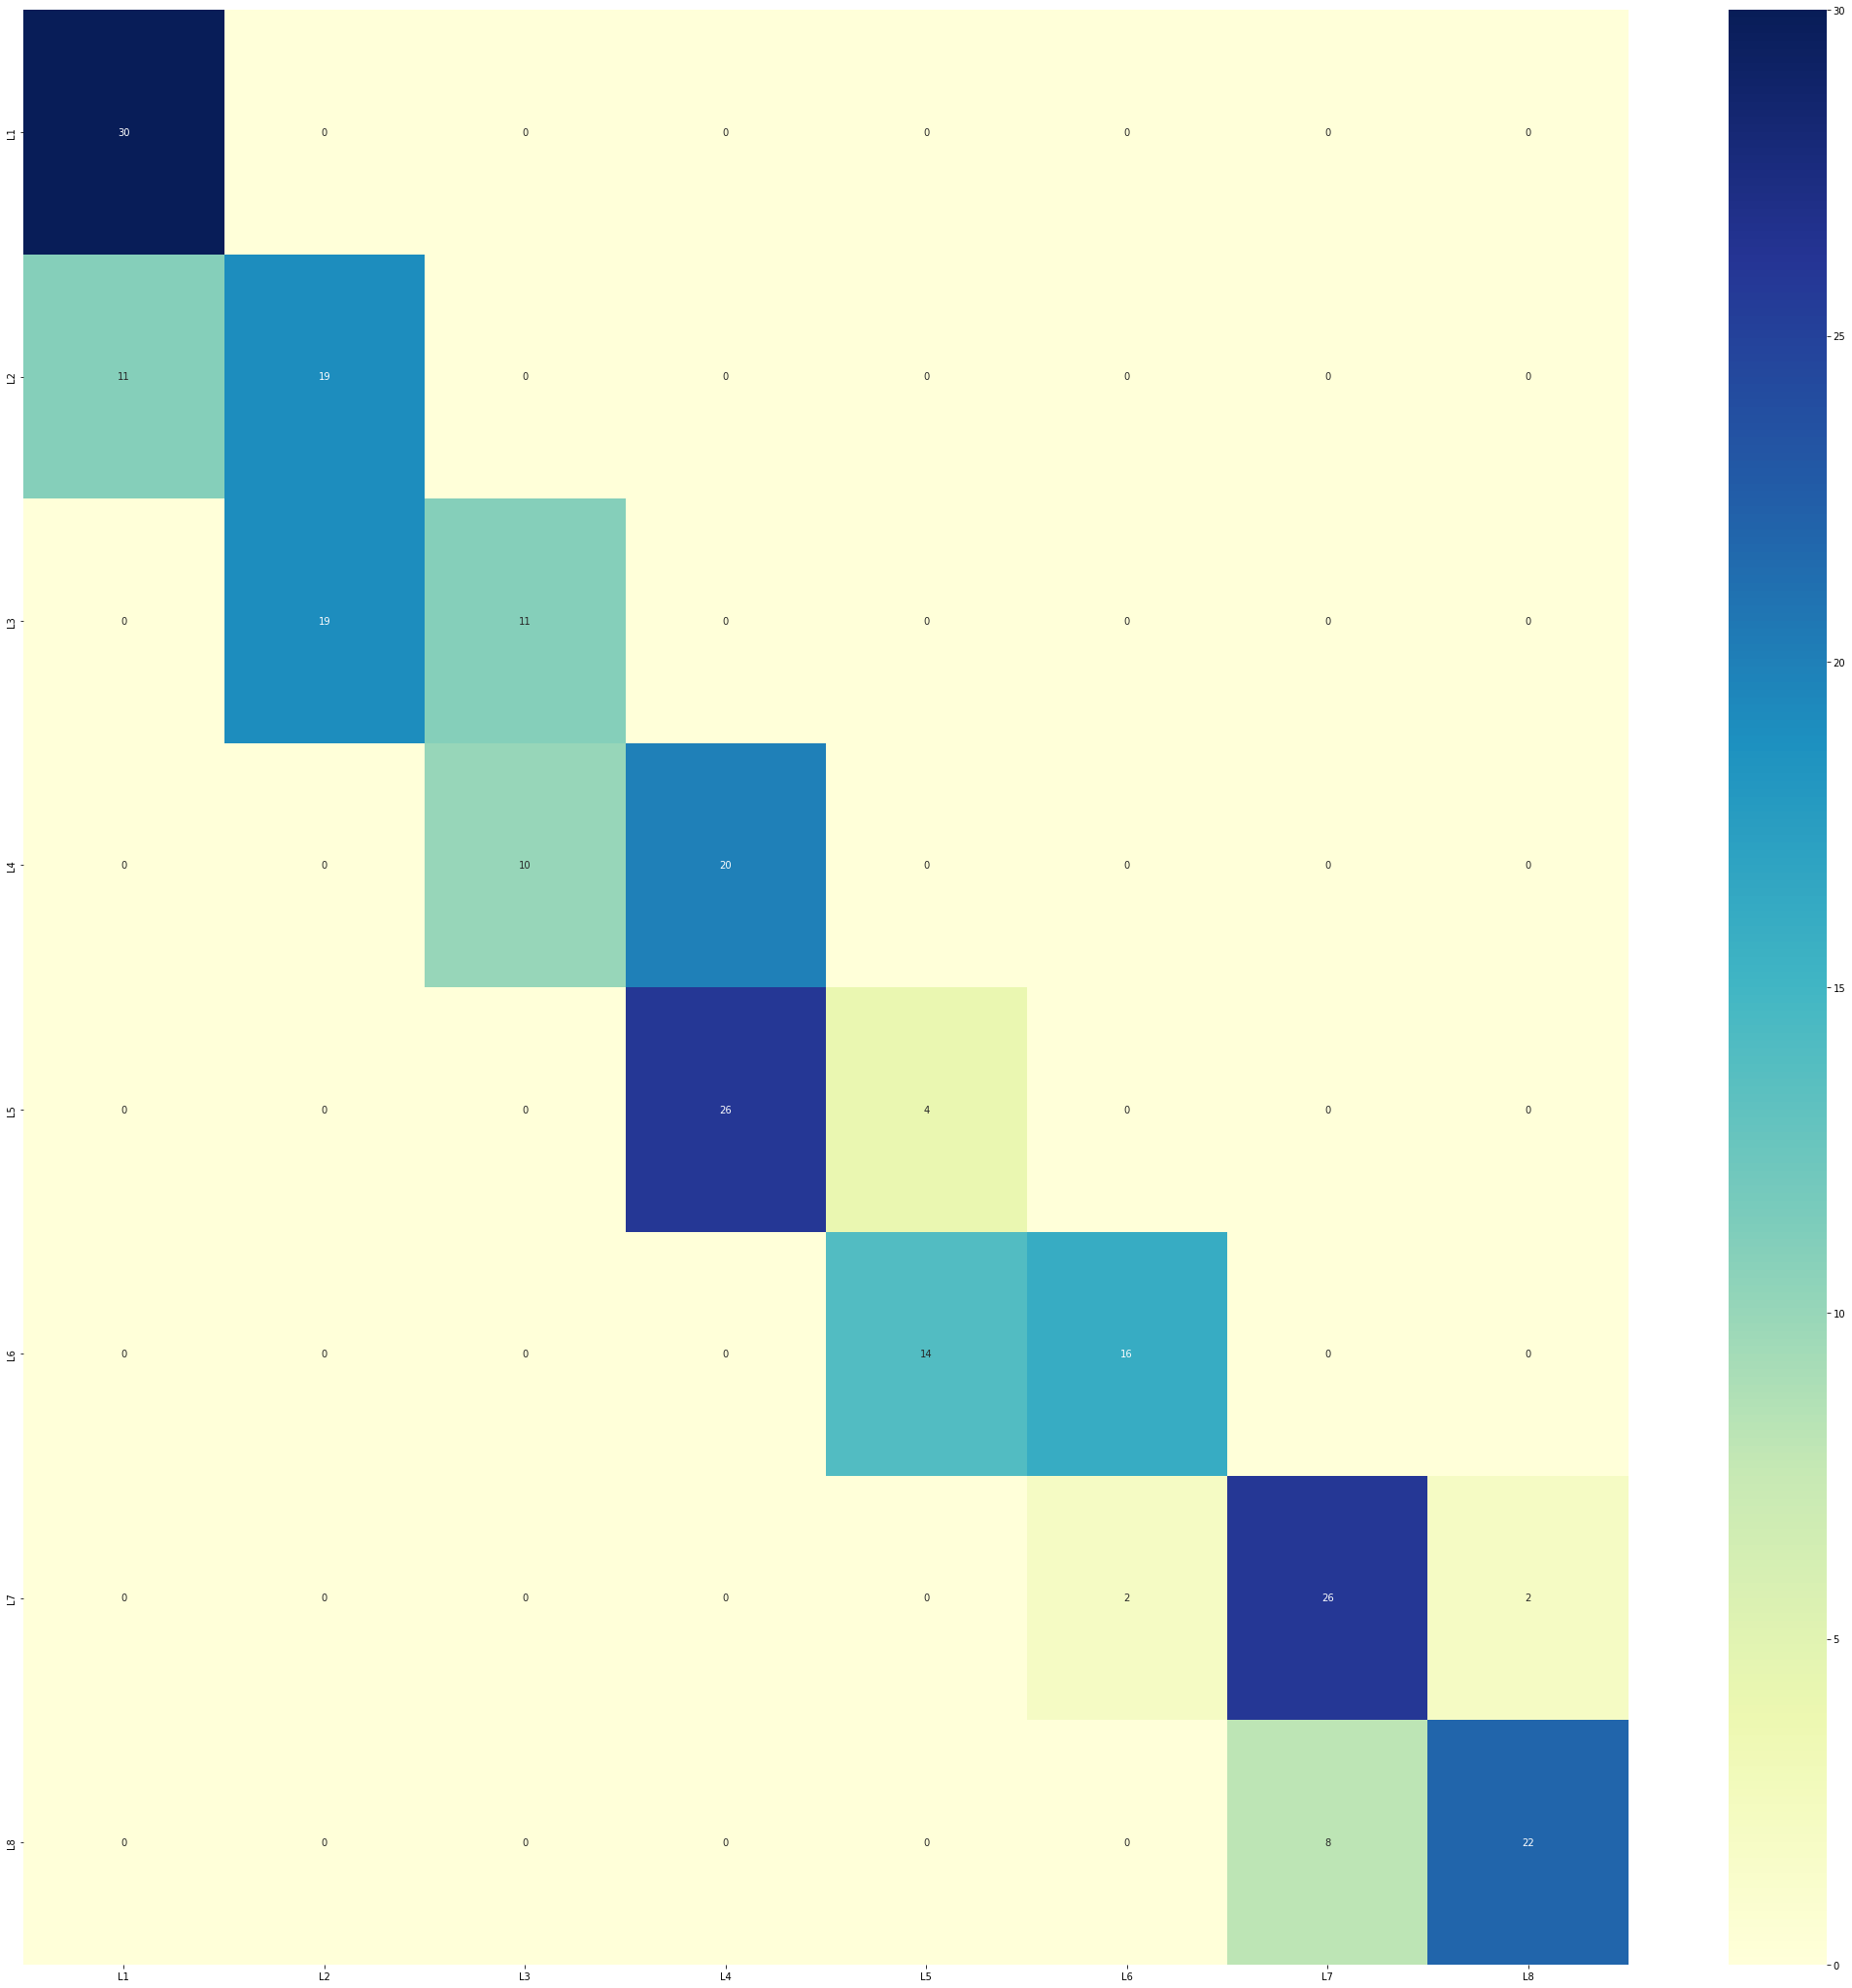

In [13]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

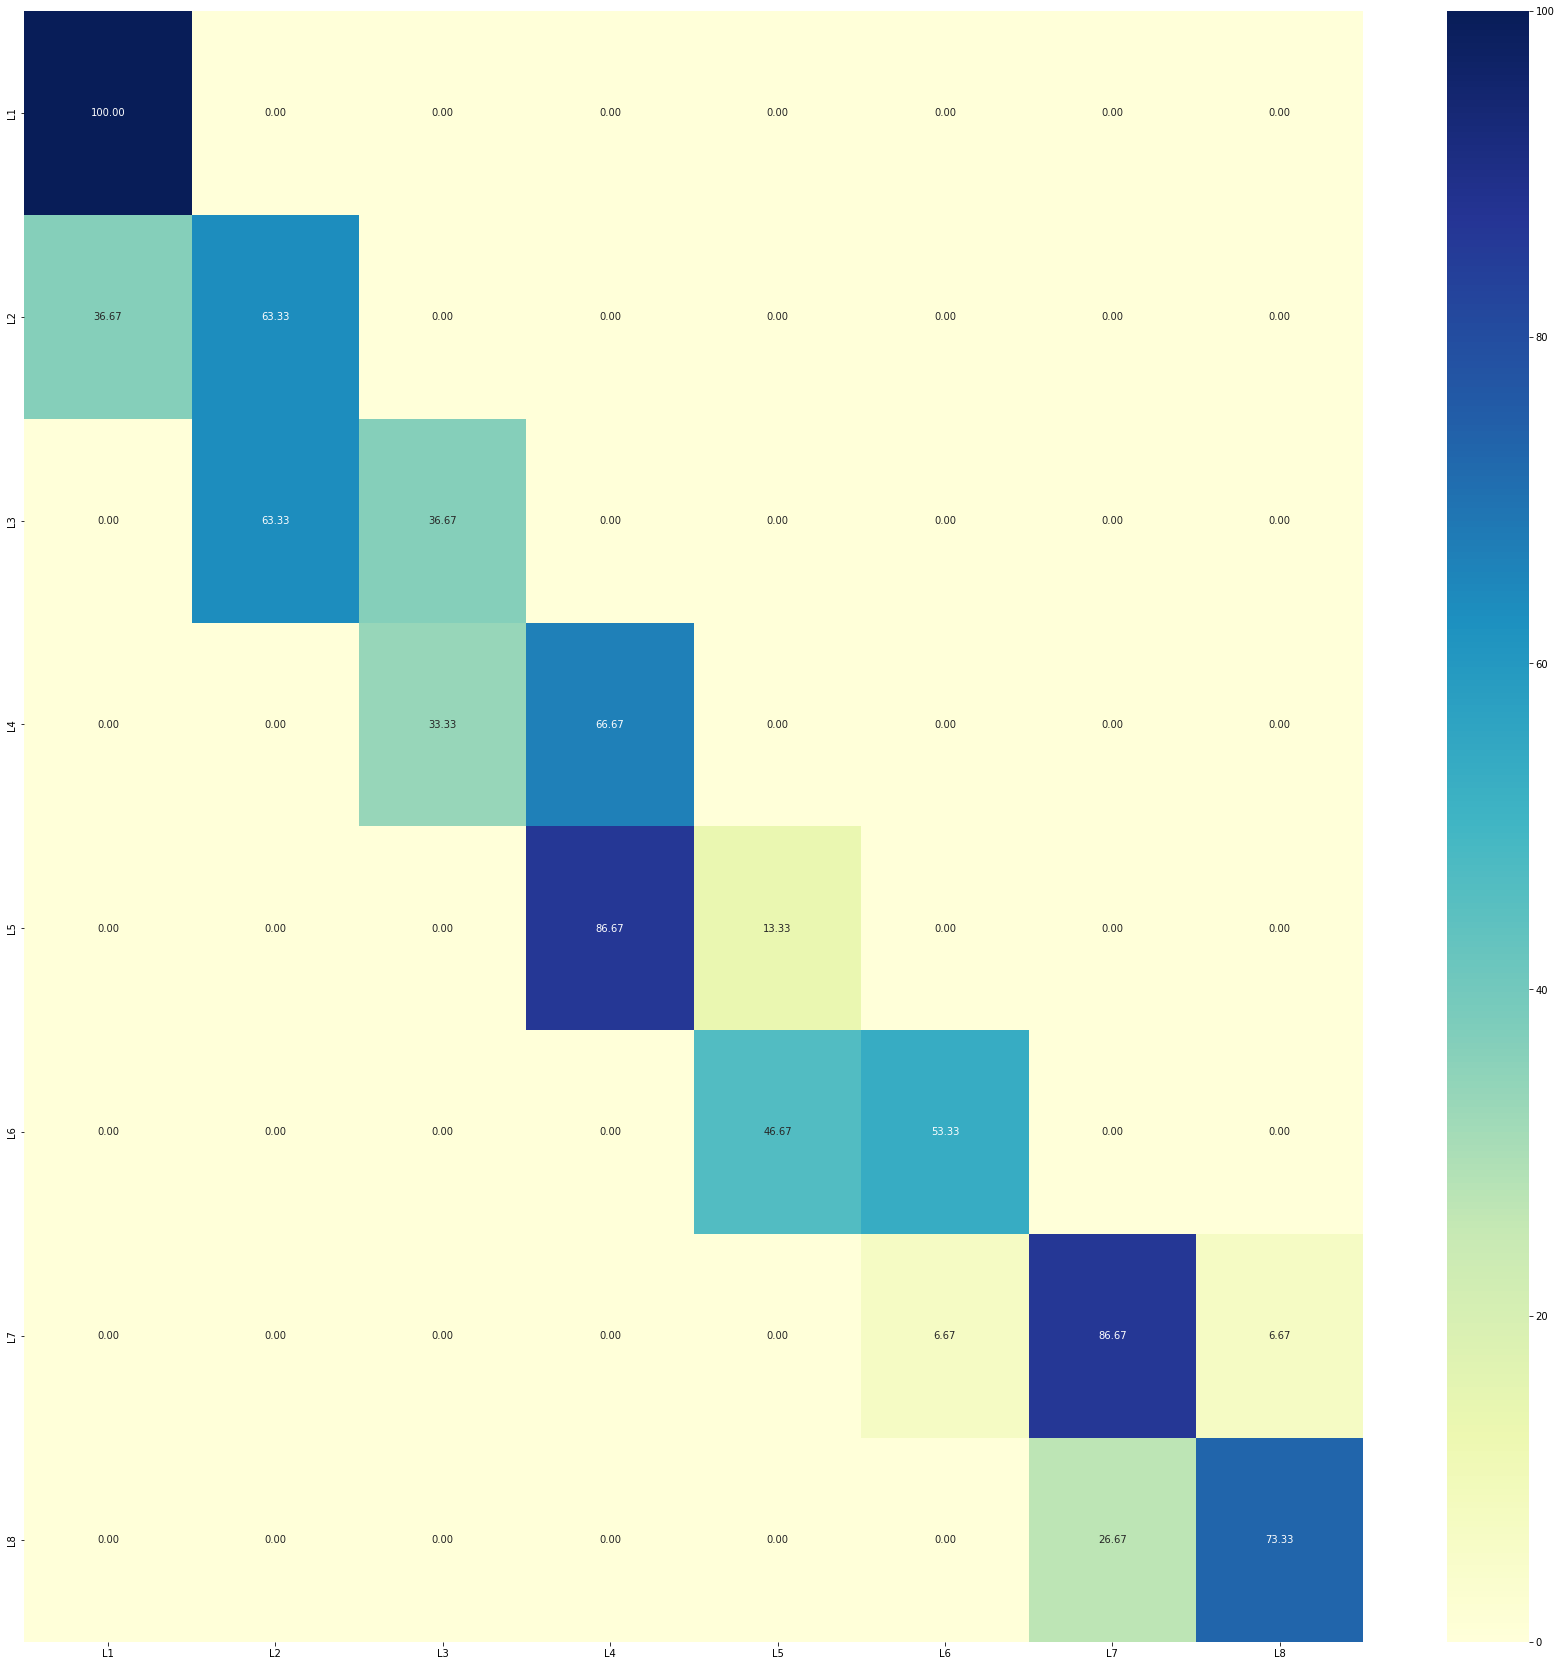

In [14]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")